In [1]:
from math import sqrt, atan2, pi, cos, sin, asin
import numpy as np

DEG2RAD = pi / 180
RAD2DEG = 180 / pi

class State:
    def __init__(self, timestamp, pos, vel, euler_angle):
        self.euler = euler_angle
        self.pos = pos
        self.vel = vel
        self.orientation = None

        self.t = timestamp

    def compute_rotation(self):
        # Convert angles from degrees to radians
        r = DEG2RAD*self.euler.x
        p = DEG2RAD*self.euler.y
        y = DEG2RAD*self.euler.z

        # Calculate trigonometric functions
        sr = sin(r)
        cr = cos(r)
        sp = sin(p)
        cp = cos(p)
        sy = sin(y)
        cy = cos(y)

        # Construct rotation matrix
        R_x = np.array([[1, 0, 0],
                        [0, cr, -sr],
                        [0, sr, cr]])

        R_y = np.array([[cp, 0, sp],
                        [0, 1, 0],
                        [-sp, 0, cp]])

        R_z = np.array([[cy, -sy, 0],
                        [sy, cy, 0],
                        [0, 0, 1]])

        self.orientation =  R_z @ R_y @ R_x
        
        return self.orientation
    
    def compute_euler(self, orientation):
        """
        Convert a 3x3 rotation matrix to roll, pitch, and yaw angles in radians.
        """
        # Extract yaw (psi)
        psi = atan2(orientation[1][0], orientation[0][0])

        # Extract pitch (theta)
        theta = atan2(-orientation[2][0], sqrt(orientation[1][0]**2 + orientation[0][0]**2))

        # Extract roll (phi)
        phi = atan2(orientation[2][1], orientation[2][2])

        self.euler = DataPacket( RAD2DEG * phi, RAD2DEG * theta, RAD2DEG * psi)

        return self.euler



class DataPacket:
    def __init__(self, x, y, z):
        self.x = x  #In case of Euler angles this is roll  
        self.y = y  #In case of Euler angles this is pitch
        self.z = z  #In case of Euler angles this is yaw

class AccelerationData:
    def __init__(self, timestamp, acceleration, gyroscope, mag, orientation):
        self.timestamp = timestamp
        self.linear_acceleration = None
        self.acceleration = acceleration
        self.gravity = None
        self.gyroscope = gyroscope
        self.mag = mag
        self.orientation = orientation
        self.sample_rate = 85 #Hz
        self.filtered_linear_acceleration = None
        self.filtered_gravity = None
        self.acc_world = None
        

    def apply_low_pass_filter(self, prev_filtered_acceleration, data_type="linear_acceleration"):

        if data_type == "linear_acceleration":
            data = self.linear_acceleration
        elif data_type == "gravity":
            data = self.gravity
        elif data_type == "gyroscope":
            data = self.gyroscope
        else:
            raise ValueError("Invalid data_type. Use 'linear_acceleration', 'gravity', or 'gyroscope'.")
        #implement a low pass filter that takes in previous filtered acceleration and new acceleration
        #and returns the new filtered acceleration

        if prev_filtered_acceleration is None:
            return data
        
        # Set the cutoff frequency
        cutoff_frequency = 5 # Hz

        # Calculate the time interval between samples
        dt = 1 / self.sample_rate

        # Calculate the smoothing parameter alpha
        alpha = dt / (1/(2*pi*cutoff_frequency) + dt)

        # Apply the low pass filter equation
        filtered_acc_x = (1 - alpha) * data.x + alpha * prev_filtered_acceleration.x
        filtered_acc_y = (1 - alpha) * data.y + alpha * prev_filtered_acceleration.y
        filtered_acc_z = (1 - alpha) * data.z + alpha * prev_filtered_acceleration.z

        # Combine the filtered x, y, and z acceleration values into a single Acceleration object
        filtered_acceleration = DataPacket(filtered_acc_x, filtered_acc_y, filtered_acc_z)

        return filtered_acceleration
    
    def compute_world_acceleration(self, orientation):
        """
        Convert the linear acceleration from the body frame to the world frame.
        """

        # Convert the linear acceleration from the body frame to the world frame
        world_acceleration = orientation @ np.array([[self.acceleration.x], 
                                                     [self.acceleration.y], 
                                                     [self.acceleration.z]])

        self.acc_world = DataPacket(world_acceleration[0][0], world_acceleration[1][0], world_acceleration[2][0])
        return world_acceleration

In [2]:
def convert_to_0_360(input):
    if input < 0:
        return input + 360
    else:
        return input
    
def convert_to_continuous(input_val, offset):
    output = input_val - offset
    if output > 180:
        output -= 360
    elif output < -180:
        output += 360
    return output

def mat2rpy(R):
    """
    Convert a 3x3 rotation matrix to roll, pitch, and yaw angles in radians.
    """
    # Extract yaw (psi)
    psi = np.arctan2(R[1][0], R[0][0])

    # Extract pitch (theta)
    theta = np.arctan2(-R[2][0], np.sqrt(R[1][0]**2 + R[0][0]**2))

    # Extract roll (phi)
    phi = np.arctan2(R[2][1], R[2][2])

    return (np.rad2deg(phi), np.rad2deg(theta), np.rad2deg(psi))

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os


f_name = 'mb_pdr_1.txt'
script_directory = os.path.abspath("")
# file_path = os.path.dirname(script_directory)
file_path = os.path.join(script_directory, "test_data", f_name)
print("file path: ",file_path)

data = pd.read_csv(file_path)
print(data.head())

# print(data.iterrows().__iter__().__next__()[1])

file path:  c:\Users\workshop\Documents\Masters-NYU\foot_mounted_pdr\test_data\mb_pdr_1.txt
         time   gyrox   gyroy   gyroz  accx  accy  accz    magx  magy  \
0  1682806937  7.3750 -1.8750  0.8125 -3.89 -1.08  9.07  34.375   8.0   
1  1682806937  7.9375 -1.8750  0.8750 -3.86 -0.81  9.12  34.375   8.0   
2  1682806937  7.8750 -1.9375  0.8125 -3.78 -0.62  9.18  34.375   8.0   
3  1682806937  7.3125 -2.0000  0.9375 -3.80 -0.61  9.16  34.000   8.0   
4  1682806937  6.5000 -1.4375  1.1250 -3.86 -0.67  9.15  34.000   8.0   

      magz    roll    pitch       yaw  
0 -30.5000 -4.6250  23.3750 -103.7500  
1 -30.5000 -4.5625  23.3750 -103.7500  
2 -30.5000 -4.5000  23.3125 -103.7500  
3 -29.6875 -4.4375  23.3125 -103.8125  
4 -29.6875 -4.3125  23.3125 -103.8125  


In [4]:
import numpy as np
class FootLocalization:
    
    #Initialize the EKF class
    def __init__(self, init_state) -> None:
        # self.timestamp = None
        self.zupt_flag = False
        self.state = init_state
        self.state_hat = None 
        self.prev_acc = np.array([[0],[0],[9.8]])
        self.data = None
        self.I = np.eye(3)
        self.K = None
        self.rolling_gyro = []
        self.dt = 0.0125
        gyr_noise = 0.01
        acc_noise = 0.1
        r_noise = 0.001
        self.R = np.diag([r_noise**2,r_noise**2,r_noise**2])
        self.P = np.zeros((9,9))
        self.Q = (np.diag([gyr_noise, gyr_noise, gyr_noise, 0, 0, 0, acc_noise, acc_noise, acc_noise])*self.dt) **2
        # self.H = np.vstack((np.array([0,0,1, 0,0,0, 0,0,0]), np.block([np.zeros((3,3)), np.zeros((3,3)), np.eye(3)])))
        self.H = np.block([np.zeros((3,3)), np.zeros((3,3)), np.eye(3)])

        if not hasattr(self, 'prev_state'):
            self.prev_state = init_state
            

    def ins(self, sensor_data):

        self.data = sensor_data
        # print(sensor_data.acc_)
        C_prev = self.prev_state.compute_rotation()
        
        gx = DEG2RAD * self.data.gyroscope.x
        gy = DEG2RAD * self.data.gyroscope.y
        gz = DEG2RAD * self.data.gyroscope.z

        # Strapdown INS system
        ang_rate = np.array([[0, -gz, gy],
                             [gz, 0, -gx],
                             [-gy, gx, 0]])
        
        update_fac = (2*self.I + ang_rate*self.dt) @ np.linalg.inv(2*self.I - ang_rate*self.dt)
        C = C_prev @ update_fac
        
        g = np.array([[0],[0],[9.8]])
        
        # print("acc: ",acc_world)
        pos_prev = np.array([[self.prev_state.pos.x],
                             [self.prev_state.pos.y],
                             [self.prev_state.pos.z]])
        
        vel_prev = np.array([[self.prev_state.vel.x],
                             [self.prev_state.vel.y],
                             [self.prev_state.vel.z]])
        
        
        acc_world = sensor_data.compute_world_acceleration((C+C_prev)*0.5)
        vel = vel_prev + (acc_world + self.prev_acc - 2*g) * self.dt
        pos = pos_prev + (vel_prev + vel) * self.dt * 0.5

        self.state.timestamp = sensor_data.timestamp
        self.state.vel   = DataPacket(vel[0][0], vel[1][0], vel[2][0])
        self.state.pos   = DataPacket(pos[0][0], pos[1][0], pos[2][0])
        self.state.euler = self.state.compute_euler(C) 
        self.state.compute_rotation()

        self.prev_acc   = acc_world
        self.prev_state = self.state

        return self.state

    def predict(self):

        self.S = np.array([[                       0    ,    -self.prev_acc[2][0]    ,      self.prev_acc[1][0]      ],
                           [     self.prev_acc[2][0]    ,                       0    ,     -self.prev_acc[0][0]      ],
                           [    -self.prev_acc[1][0]    ,     self.prev_acc[0][0]    ,                        0      ]])
        
        self.F = np.block([[         np.eye(3)   ,   np.zeros((3,3))   ,     np.zeros((3,3))  ],
                           [   np.zeros((3,3))   ,         np.eye(3)   ,   np.eye(3)*self.dt  ],
                           [   -self.S*self.dt   ,   np.zeros((3,3))   ,           np.eye(3)  ]])
        
        self.P = self.F @ self.P @ self.F.T + self.Q
        

    def update(self, state):

        self.K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)
        I = np.eye(9)
        error = self.get_error(state)

        self.P = (I - self.K @ self.H) @ self.P

        ang_rate_correction = np.array([[          0         ,      error[2][0]     ,    -error[1][0]     ],
                                        [    -error[2][0]    ,            0         ,     error[0][0]     ],
                                        [     error[1][0]    ,     -error[0][0]     ,             0       ]])
        

        try:
            correction_factor = (2*self.I + ang_rate_correction) @ np.linalg.inv(2*self.I - ang_rate_correction)
        except:
            print("error: ", error)

        state.orientation = state.orientation @ correction_factor
        state.euler = state.compute_euler(state.orientation)
        state.pos = DataPacket(state.pos.x - error[3][0], state.pos.y - error[4][0], state.pos.z - error[5][0])
        state.vel = DataPacket(state.vel.x - error[6][0], state.vel.y - error[7][0], state.vel.z - error[8][0])
        
        self.state = state
        self.prev_state = state

        return state

    def get_error(self, state):

        vel = np.array([[state.vel.x],
                        [state.vel.y],
                        [state.vel.z]])
        
        return self.K@vel

    def check_zupt(self, sensor_data):
        # print("zupt check executed")
        self.rolling_gyro.append(sensor_data.gyroscope)
        if len(self.rolling_gyro) > 5:
            self.rolling_gyro.pop(0)

        val = 0
        
        for data in self.rolling_gyro:
            val += sqrt(data.x**2 + data.y**2 + data.z**2)
            self.gyro_avg = val / len(self.rolling_gyro)

        if self.gyro_avg < 25:
            self.zupt_flag = True
            return True
        else:
            self.zupt_flag = False
            return False
            

In [6]:
states = []
zupt = []
acc = []

for n,packet in enumerate(data.iterrows()):
    # Parse the data
    
    gyro_data = DataPacket( packet[1]['gyrox'], packet[1]['gyroy'], packet[1]['gyroz'] )
    acc_data  = DataPacket(  packet[1]['accx'],  packet[1]['accy'],  packet[1]['accz'] )
    mag_data  = DataPacket(  packet[1]['magx'],  packet[1]['magy'],  packet[1]['magz'] )
    eul_data  = DataPacket(  packet[1]['roll'], packet[1]['pitch'],   packet[1]['yaw'] )
    timestamp = packet[1]['time']

    if packet[0] == 0:
        eul_data = DataPacket( RAD2DEG * (atan2(acc_data.y/9.8,acc_data.z/9.8)), -RAD2DEG * asin(acc_data.x/9.8), packet[1]['yaw'] - 180)
        init_state = State(timestamp, DataPacket(0,0,0), DataPacket(0,0,0), eul_data)
        ekf = FootLocalization(init_state)
        continue

    data_packet = AccelerationData(timestamp, acc_data, gyro_data, mag_data, eul_data)

    # Perform INS

    state_apriori = ekf.ins(data_packet)
    ekf.predict()
    acc.append(data_packet.acc_world)    

    step_detected = ekf.check_zupt(data_packet)     # Check for ZUPT
    zupt.append(step_detected) 
    
    if step_detected:
        state_aposteriori = ekf.update(state_apriori)

    else:
        state_aposteriori = state_apriori

    states.append(State(state_aposteriori.timestamp, state_aposteriori.pos, state_aposteriori.vel, state_aposteriori.euler))
             

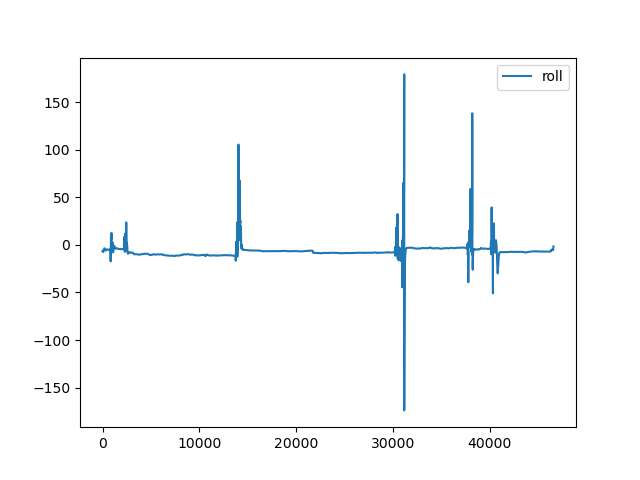

In [7]:
r,p,y = [],[],[]
posx, posy, posz = [],[],[]
velx, vely, velz = [],[],[]
accx, accy, accz = [],[],[]

for state in states:
    # phi, theta, psi = mat2rpy(state.orientation)
    r.append(state.euler.x)
    p.append(state.euler.y)
    y.append(state.euler.z)
    posx.append(state.pos.x)
    posy.append(state.pos.y)
    posz.append(state.pos.z)
    velx.append(state.vel.x)
    vely.append(state.vel.y)
    velz.append(state.vel.z)
    
for a in acc:
    accx.append(a.x)
    accy.append(a.y)
    accz.append(a.z)

%matplotlib widget

#plot the data
plt.figure()
plt.plot(r, label='roll')
# plt.plot(p, label='pitch')
# plt.plot(y, label='yaw')
# plt.plot(accx, label='acc')
# plt.plot(zupt, label='zupt')
plt.legend()
plt.show()


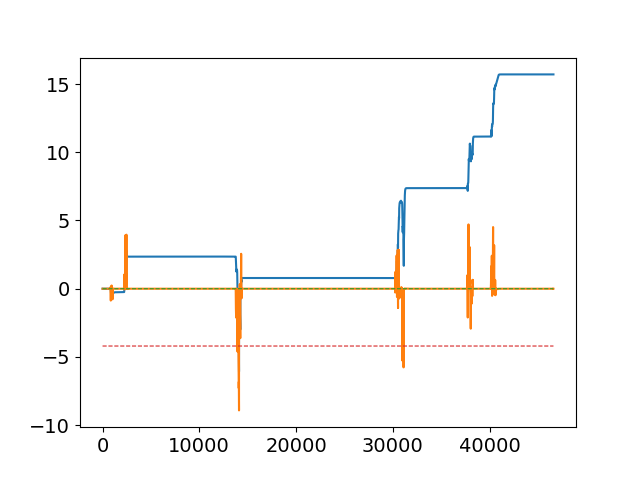

In [8]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(posx, linestyle = 'solid',  label = 'pos')
plt.plot(velx, linestyle = 'solid',  label = 'vel')
plt.plot( np.zeros(len(posx)), linestyle = '--', linewidth = 0.8)
plt.plot(-4.2*np.ones(len(posx)), linestyle = '--', linewidth = 0.8)

Text(0.5, 1.0, 'Position in XY')

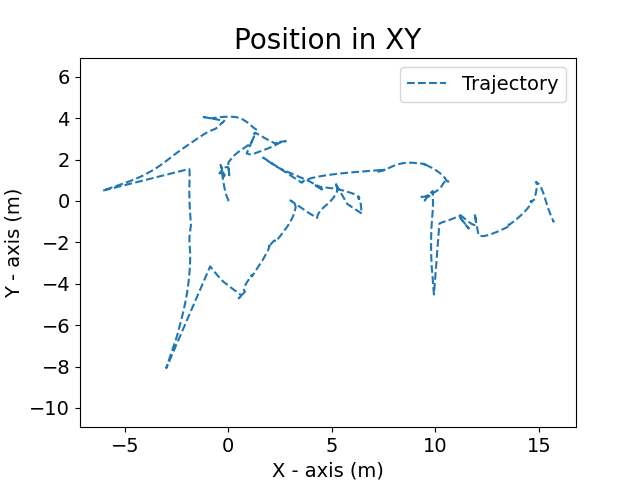

In [9]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(posx,posy, linestyle = '--',  label = 'Trajectory')
# plt.plot(pos[0,0],pos[0,1],'x', color = 'red', label = 'GT')

plt.xlabel('X - axis (m)')
plt.ylabel('Y - axis (m)')
plt.title('XY')
plt.axis('equal')
# plt.ylim(-0.25,0.25)
plt.legend()

plt.title('Position in XY', fontsize =20 )